In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Storytelling
L'obbiettivo di questa analisi è mostrare/vedere l'impatto dei cartellini rossi e gialli sul risultato delle partite e sulla performance delle squadre

In [78]:
# Load data from CSV files
games = pd.read_csv('./data/games.csv')
game_events = pd.read_csv('./data/game_events.csv')


0.9573934441745275
0.042606555825472445
336325


In [102]:
# Gestire i valori nulli nella colonna 'description'
game_events['description'] = game_events['description'].fillna('')

# Filtrare i cartellini gialli e rossi
num_yellow = game_events[(game_events['type'] == 'Cards') & (game_events['description'].str.contains('yellow', case=False))]
num_red = game_events[(game_events['type'] == 'Cards') & (game_events['description'].str.contains('red', case=False) | game_events['description'].str.contains('second', case=False))]
num_tot = game_events[game_events['type'] == 'Cards']

print(
    f'Numero cartellini rossi: {len(num_red)} \n',
    f'Numero cartellini gialli: {len(num_yellow)} \n',
    f'Numero cartellini totali: {len(num_tot)}'
)


Numero cartellini rossi: 3585 
 Numero cartellini gialli: 60693 
 Numero cartellini totali: 62473


Vediamo che la stragrande maggioranza dei cartellini sono cartellini gialli <br>
perciò sostiuiremo i valori vuoti con cartellini gialli

## Creazione tabella 
per comodità creiamo un nuovo file che contenga le informazioni che ci interessano per fare le nostre considerazioni:
il numero di cartellini ricevuti, il numero di goal fatti e ricevuti e il risultato della partita

In [79]:
import pandas as pd

not_nan = game_events.copy()
not_nan = not_nan.fillna('yellow') # riempiamo con il valore più comune

# Funzione per contare i cartellini in base al tipo specificato
def count_cards(game_id, club_id, card_type=None):
    events = not_nan[(not_nan['game_id'] == game_id) & (not_nan['club_id'] == club_id)]
    if card_type is None:
        return len(events[events['type'] == 'Cards'])
    elif card_type == 'yellow':
        return len(events[
            (events['type'] == 'Cards') &
            (events['description'].str.contains('yellow', case=False)) &
            (~events['description'].str.contains('second', case=False))
        ])
    elif card_type == 'red':
        return len(events[
            (events['type'] == 'Cards') &
            (events['description'].str.contains('red', case=False) | 
             events['description'].str.contains('second', case=False))
        ])

# Creiamo il nuovo dataframe che contenga i dati sopra citati
transformed_games = []

# Transform the games data
for index, row in games.iterrows():
    home_row = {
        'game_id': row['game_id'],
        'club_id': row['home_club_id'],
        'date': row['date'],
        'competition_id': row['competition_id'],
        'season': row['season'],
        'round': row['round'],
        'goals_received': row['away_club_goals'],
        'goals_made': row['home_club_goals'],
        'cards_received': count_cards(row['game_id'], row['home_club_id']),
        'cards_received_yellow': count_cards(row['game_id'], row['home_club_id'], 'yellow'),
        'cards_received_red': count_cards(row['game_id'], row['home_club_id'], 'red'),
        'is_win': 1 if row['home_club_goals'] > row['away_club_goals'] else (
            0 if row['home_club_goals'] < row['away_club_goals'] else -1)
    }

    away_row = {
        'game_id': row['game_id'],
        'club_id': row['away_club_id'],
        'date': row['date'],
        'competition_id': row['competition_id'],
        'season': row['season'],
        'round': row['round'],
        'goals_received': row['home_club_goals'],
        'goals_made': row['away_club_goals'],
        'cards_received': count_cards(row['game_id'], row['away_club_id']),
        'cards_received_yellow': count_cards(row['game_id'], row['away_club_id'], 'yellow'),
        'cards_received_red': count_cards(row['game_id'], row['away_club_id'], 'red'),
        'is_win': 1 if row['away_club_goals'] > row['home_club_goals'] else (
            0 if row['away_club_goals'] < row['home_club_goals'] else -1)
    }

    transformed_games.append(home_row)
    transformed_games.append(away_row)

# Convertiamo la struttura in un dataframe di panda e salviamolo in un nuovo csv
transformed_games_df = pd.DataFrame(transformed_games)

# Verifica del dataframe per assicurarsi che le colonne siano presenti e corrette
print(transformed_games_df.head())

# Salviamo il DataFrame nel CSV
transformed_games_df.to_csv('./data/transformed_games2.csv', index=False)


   game_id  club_id        date competition_id  season         round  \
0  2222597     3725  2012-08-25            RU1    2012   6. Matchday   
1  2222597      232  2012-08-25            RU1    2012   6. Matchday   
2  2222627     2696  2012-08-20            RU1    2012   5. Matchday   
3  2222627     4128  2012-08-20            RU1    2012   5. Matchday   
4  2222658     2410  2012-09-30            RU1    2012  10. Matchday   

   goals_received  goals_made  cards_received  cards_received_yellow  \
0               1           2               2                      2   
1               2           1               3                      3   
2               2           0               3                      2   
3               0           2               0                      0   
4               2           0               1                      0   

   cards_received_red  is_win  
0                   0       1  
1                   0       0  
2                   1       0  
3     

In [86]:
games_df = pd.read_csv('data/transformed_games2.csv')
games_df['cards_received_yellow'].sum()

58888

## Data Cleaning:

### 1) Distribuzione dei valori di cards_received:

In [81]:
# Intanto vediamo qual'è la distribuzione del numero di cartellini 
print(
    f' Massimo e minimo tra i valori di cards_received: \n {games_df['cards_received'].min()} {games_df['cards_received'].max()}')

# Vediamo che il massimo è 11 cartellini, che essendo veramente tanti sarebbe meglio controllare il numero di record per ciascun valore 
(games_df['cards_received']).value_counts().sort_index()

# Vediamo che il numero di record con un valore di numero cartellini compreso tra 5 e 11 è davvero basso. Ciò potrebbe portare a risultati fallati. 
# Potrebbe essere una buona idea raggruppare i valori maggiori di 4 in un unica etichetta '5+'
games_df['cards_received'] = games_df['cards_received'].apply(lambda x: 5 if x >= 5 else x)
(games_df['cards_received']).value_counts().sort_index()



 Massimo e minimo tra i valori di cards_received: 
 0 11


cards_received
0    105375
1      6872
2      7440
3      5522
4      3070
5      2153
Name: count, dtype: int64

# Analisi:

 ## differenza di probabilità di sconfitta in base al numero di cartellini ricevuti <br>
 Per poter visualizzare questa eventualità utilizzeremo una heatmap per mettere in relazione la probabilità di sconfitta con il numero di cartellini ricevuti

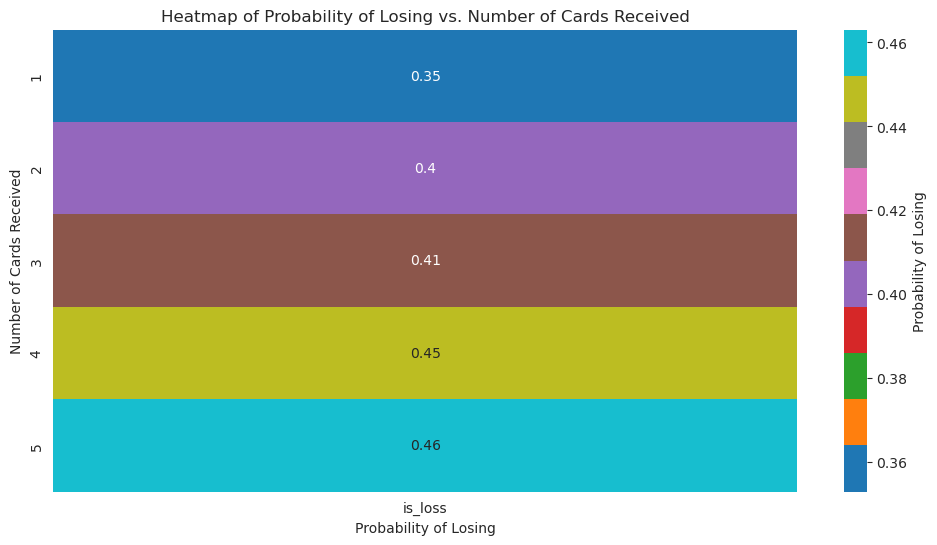

In [82]:
# Filtrare le partite con numero di cartellini maggiore di 0
games_with_cards = (games_df[games_df['cards_received'] > 0]).copy()

games_with_cards.loc[:, 'is_loss'] = games_with_cards['is_win'].apply(
    lambda x: 1 if x == 0 else 0)  # per semplicità aggiungiamo una colonna is_loss

# contiene come index il numero di cartellini e come valore la probabilità di sconfitta
pivot_table = games_with_cards.pivot_table(values='is_loss', index='cards_received', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.color_palette("hls", 8)
sns.heatmap(pivot_table, annot=True, cmap='tab10', cbar_kws={'label': 'Probability of Losing'})
plt.title('Heatmap of Probability of Losing vs. Number of Cards Received')
plt.xlabel('Probability of Losing')
plt.ylabel('Number of Cards Received')
plt.show()


Sembra effettivamente che la probabilità di sconfitta aumenti all'aumentare dell'numero di cartellini

## Probabilità di sconfitta in base al numero di cartellini gialli e rossi

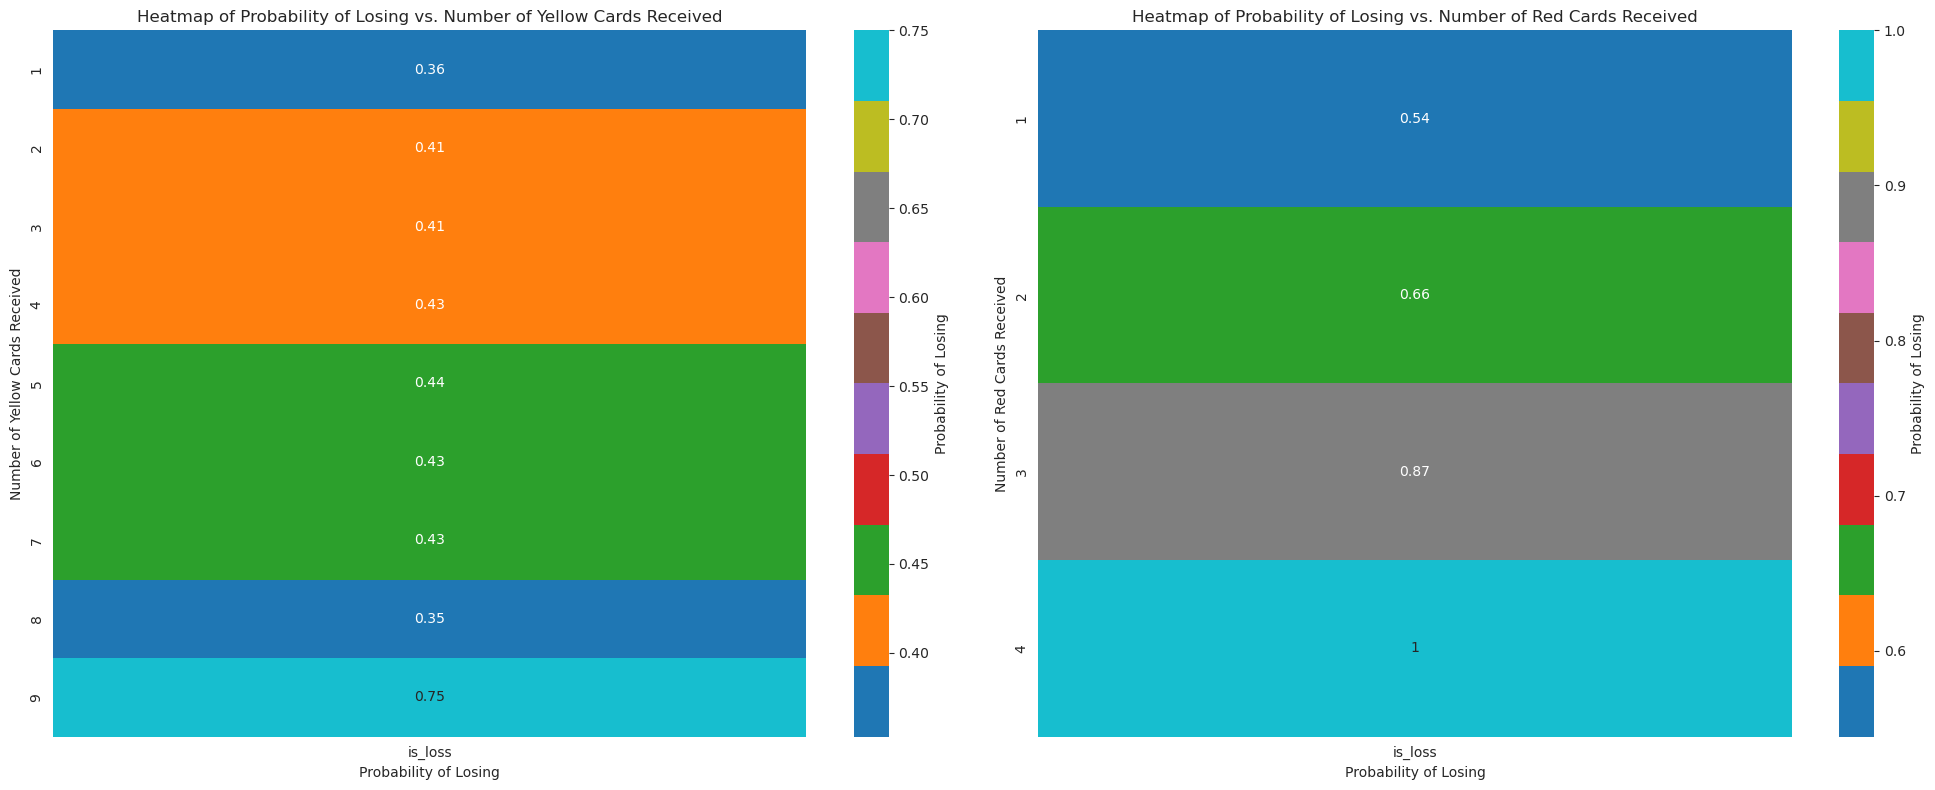

In [95]:
games_with_yellow_cards = (games_df[games_df['cards_received_yellow'] > 0]).copy()

games_with_yellow_cards.loc[:, 'is_loss'] = games_with_yellow_cards['is_win'].apply(
    lambda x: 1 if x == 0 else 0) 

pivot_table_yellow = games_with_yellow_cards.pivot_table(values='is_loss', index='cards_received_yellow', aggfunc='mean')

games_with_red_cards = (games_df[games_df['cards_received_red'] > 0]).copy()

games_with_red_cards.loc[:, 'is_loss'] = games_with_red_cards['is_win'].apply(
    lambda x: 1 if x == 0 else 0)  

pivot_table_red = games_with_red_cards.pivot_table(values='is_loss', index='cards_received_red', aggfunc='mean')

# Creare una figura con due subplot affiancati
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap per cartellini gialli
sns.heatmap(pivot_table_yellow, annot=True, cmap='tab10', cbar_kws={'label': 'Probability of Losing'}, ax=ax[0])
ax[0].set_title('Heatmap of Probability of Losing vs. Number of Yellow Cards Received')
ax[0].set_xlabel('Probability of Losing')
ax[0].set_ylabel('Number of Yellow Cards Received')

# Heatmap per cartellini rossi
sns.heatmap(pivot_table_red, annot=True, cmap='tab10', cbar_kws={'label': 'Probability of Losing'}, ax=ax[1])
ax[1].set_title('Heatmap of Probability of Losing vs. Number of Red Cards Received')
ax[1].set_xlabel('Probability of Losing')
ax[1].set_ylabel('Number of Red Cards Received')

plt.tight_layout()
plt.show()


Vediamo che anche in questo caso al crescere del numero di cartellini gialli o rossi la probabilità di sconfitta sale di conseguenza.